In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping 
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# transfer learning
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False)  #224 pixels * 224 pixels with 3 color channels (RGB)
# include_top=False means we don't include the final classification layers of VGG16 so reduce computation
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to one dimension 
    Dense(128, activation='relu'),  # optional hidden layer
    Dense(5, activation='softmax')  # main output layer for 5 classes 
])
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,725 (68.39 MB)

 Trainable params: 3,212,037 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [3]:
# tf flowers dataset
dataset, info = tfds.load('tf_flowers', with_info=True,as_supervised=True)

In [4]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [5]:
n_classes = info.features['label'].num_classes
n_classes

5

In [6]:
IMG_SIZE = 224


In [7]:
images , labels = [] , []
for image, label in tfds.as_numpy(dataset['train']):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    images.append(image)
    labels.append(label)

In [8]:
images=np.array(images)
labels=np.array(labels)
labels.shape

(3670,)

In [9]:
X_train , X_test , y_train , y_test = train_test_split(images , labels , test_size=0.2 , random_state=42)

In [10]:

train_datagen = ImageDataGenerator(
    rescale=1./255)   # rescale pixel values to [0, 1] range
test_datagen = ImageDataGenerator(
    rescale=1./255)     

In [11]:
train_generator = train_datagen.flow(
    tf.image.resize(X_train, (IMG_SIZE, IMG_SIZE)).numpy(),
    tf.keras.utils.to_categorical(y_train, num_classes=n_classes),
)
test_generator = test_datagen.flow(
    tf.image.resize(X_test, (IMG_SIZE, IMG_SIZE)).numpy(),
    tf.keras.utils.to_categorical(y_test, num_classes=n_classes),
)

In [12]:
history = model.fit(train_generator, validation_data=test_generator, epochs=5)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 482ms/step - accuracy: 0.5425 - loss: 1.7416 - val_accuracy: 0.7493 - val_loss: 0.7219
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.8798 - loss: 0.3745 - val_accuracy: 0.7466 - val_loss: 0.6777
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.9545 - loss: 0.1762 - val_accuracy: 0.8065 - val_loss: 0.5267
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.9903 - loss: 0.0800 - val_accuracy: 0.7970 - val_loss: 0.5652
Epoch 5/5
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9978 - loss: 0.0389

KeyboardInterrupt: 

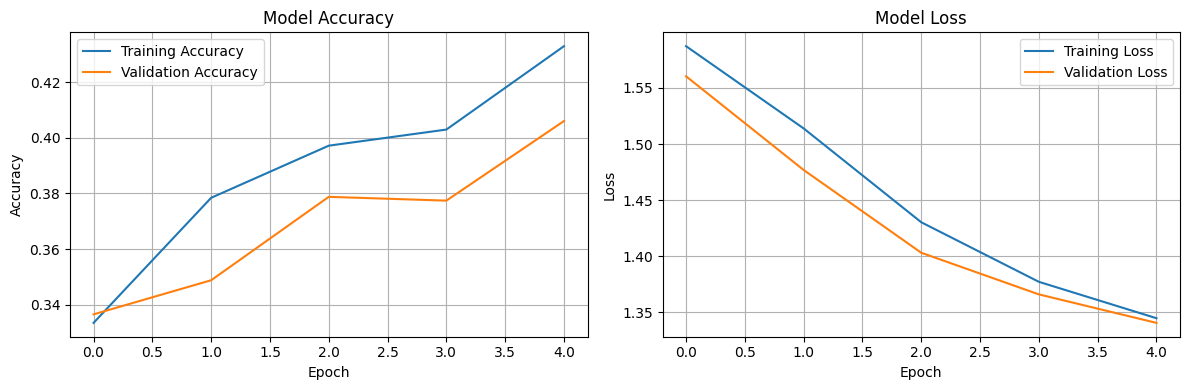

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
for layer in base_model.layers[-4:]:  # unfreeze the last 4 layers
    layer.trainable = True
model_fine = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to one dimension 
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])
model_fine.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
                metrics=['accuracy'])
model_fine.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1000)           │   138,357,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,486,317 (528.28 MB)

 Trainable params: 123,771,629 (472.15 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history_fine = model_fine.fit(train_generator, validation_data=test_generator, epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.4005 - loss: 1.3922 - val_accuracy: 0.4033 - val_loss: 1.3685
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.4096 - loss: 1.3725 - val_accuracy: 0.4373 - val_loss: 1.3411
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.4416 - loss: 1.3142 - val_accuracy: 0.4482 - val_loss: 1.3213
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.4491 - loss: 1.3204 - val_accuracy: 0.4809 - val_loss: 1.2973
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - accuracy: 0.4880 - loss: 1.2744 - val_accuracy: 0.4864 - val_loss: 1.2785


## Hyper Parameters Tuning

In [14]:
!pip install keras-tuner

In [15]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.datasets import mnist


/tmp/ipython-input-810850452.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [20]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
 

In [23]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [24]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_test.head()

In [25]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(
        Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu')
        #activastion function is not considered a hyperparameter as it changes the nature of the model
    )
    model.add(
        Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu')
    )

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.001,0.01,0.1])),
                  loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return model



In [27]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='simple_tuning',
    project_name='mnist_tuning'
)

In [28]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test) , batch_size=32)

Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.9646999835968018

Best val_accuracy So Far: 0.9646999835968018
Total elapsed time: 00h 02m 35s


In [29]:
tuner.results_summary()

Results summary
Results in simple_tuning/mnist_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
units_1: 32
units_2: 64
learning_rate: 0.001
Score: 0.9646999835968018

Trial 4 summary
Hyperparameters:
units_1: 256
units_2: 64
learning_rate: 0.01
Score: 0.9646999835968018

Trial 2 summary
Hyperparameters:
units_1: 256
units_2: 96
learning_rate: 0.1
Score: 0.27559998631477356

Trial 3 summary
Hyperparameters:
units_1: 96
units_2: 32
learning_rate: 0.1
Score: 0.12849999964237213

Trial 0 summary
Hyperparameters:
units_1: 96
units_2: 256
learning_rate: 0.1
Score: 0.11349999904632568


In [30]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [31]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,882 (108.91 KB)

 Trainable params: 27,882 (108.91 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
best_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_parameters.values

{'units_1': 32, 'units_2': 64, 'learning_rate': 0.001}

In [37]:
model_2= Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(units=best_parameters.get('units_1'), activation='relu'),
    Dense(units=best_parameters.get('units_2'), activation='relu'),
    Dense(10, activation='softmax')
])
model_2.compile(optimizer=Adam(learning_rate=best_parameters.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
model_2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8358 - loss: 0.5664 - val_accuracy: 0.9439 - val_loss: 0.1782
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9500 - loss: 0.1659 - val_accuracy: 0.9575 - val_loss: 0.1391
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9628 - loss: 0.1262 - val_accuracy: 0.9623 - val_loss: 0.1215
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9691 - loss: 0.1037 - val_accuracy: 0.9681 - val_loss: 0.1081
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9741 - loss: 0.0846 - val_accuracy: 0.9682 - val_loss: 0.1070
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9776 - loss: 0.0736 - val_accuracy: 0.9674 - val_loss: 0.1169
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9784 - loss: 0.0694 - val_accuracy: 0.9679 - val_loss: 0.1113
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9817 - loss: 0.0594 - 